# Trace Analysis Examples

## Tasks Latencies

This notebook shows the features provided for task latency profiling. It will be necessary to collect the following events:
 
Details on idle states profiling ar given in **Latency DataFrames and Latency Plots ** below.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2016-12-12 12:58:10,343 INFO    : root         : Using LISA logging configuration:
2016-12-12 12:58:10,344 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',
    "password"    : 'juno',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_TaskLatencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2016-12-12 12:58:17,443 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-12 12:58:17,444 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-12 12:58:17,444 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq']
2016-12-12 12:58:17,445 INFO    : TestEnv      : Connecting linux target:
2016-12-12 12:58:17,445 INFO    : TestEnv      :   username : root
2016-12-12 12:58:17,446 INFO    : TestEnv      :       host : 192.168.0.1
2016-12-12 12:58:17,446 INFO    : TestEnv      :   password : juno
2016-12-12 12:58:17,447 INFO    : TestEnv      : Connection settings:
2016-12-12 12:58:17,447 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2016-12-12 12:58:24,242 INFO    : TestEnv      : Initializing target workdir:
2016-12-12 12:58:24,243 INFO    : TestEnv      :    /root/devlib-target
2016-12-12 12:58:40,880 INFO    : TestEnv      : Topology:
2016-12-12 12:58:40,881 INFO    : TestEnv      :    [

## Workload Configuration and Execution

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

2016-12-12 12:58:52,280 INFO    : Workload     : Setup new workload ramp
2016-12-12 12:58:52,281 INFO    : Workload     : Workload duration defined by longest task
2016-12-12 12:58:52,282 INFO    : Workload     : Default policy: SCHED_OTHER
2016-12-12 12:58:52,282 INFO    : Workload     : ------------------------
2016-12-12 12:58:52,283 INFO    : Workload     : task [ramp], sched: using default policy
2016-12-12 12:58:52,283 INFO    : Workload     :  | calibration CPU: 1
2016-12-12 12:58:52,284 INFO    : Workload     :  | loops count: 1
2016-12-12 12:58:52,284 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (5 loops)
2016-12-12 12:58:52,285 INFO    : Workload     : |  period   100000 [us], duty_cycle  60 %
2016-12-12 12:58:52,285 INFO    : Workload     : |  run_time  60000 [us], sleep_time  40000 [us]
2016-12-12 12:58:52,286 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (5 loops)
2016-12-12 12:58:52,286 INFO    : Workload     : |  period   100000 [us], d

## Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2016-12-12 12:59:36,883 INFO    : root         : Content of the output folder /home/vagrant/lisa/results/TraceAnalysis_TaskLatencies


/home/vagrant/lisa/results/TraceAnalysis_TaskLatencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
└── trace.dat

0 directories, 5 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

2016-12-12 12:59:38,100 INFO    : root         : LITTLE cluster max capacity: 447


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

2016-12-12 12:59:39,175 INFO    : Trace        : Parsing FTrace format...
2016-12-12 12:59:39,536 INFO    : Trace        : Collected events spans a 13.065 [s] time interval
2016-12-12 12:59:39,536 INFO    : Trace        : Set plots time range to (0.000000, 13.064847)[s]
2016-12-12 12:59:39,537 INFO    : Analysis     : Registering trace analysis modules:
2016-12-12 12:59:39,538 INFO    : Analysis     :    tasks
2016-12-12 12:59:39,539 INFO    : Analysis     :    status
2016-12-12 12:59:39,539 INFO    : Analysis     :    frequency
2016-12-12 12:59:39,540 INFO    : Analysis     :    cpus
2016-12-12 12:59:39,541 INFO    : Analysis     :    latency
2016-12-12 12:59:39,541 INFO    : Analysis     :    idle
2016-12-12 12:59:39,542 INFO    : Analysis     :    functions
2016-12-12 12:59:39,542 INFO    : Analysis     :    eas


## Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

## Latency DataFrames

In [11]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
1.773515,NaN,1.0,A,S,1.773515,0.086343
1.859858,NaN,1.0,S,W,1.859858,0.013899
1.873757,1.0,NaN,W,A,1.873757,0.000010
1.873767,NaN,1.0,A,S,1.873767,0.059513
1.933280,NaN,1.0,S,W,1.933280,0.040525


In [12]:
# Report information on sched_switch events
df = trace.data_frame.trace_event('sched_switch')
df.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.000007,trace-cmd,2,935,swapper/2,0,120,trace-cmd,935,120,64
0.000108,<idle>,1,0,sh,934,120,swapper/1,0,120,0
0.000501,<idle>,2,0,sudo,933,120,swapper/2,0,120,0
0.000507,sh,1,934,swapper/1,0,120,sh,934,120,64
0.000691,<idle>,1,0,rcu_preempt,7,120,swapper/1,0,120,0


In [13]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
1.873757,0.000010
1.973805,0.000020
2.073804,0.000023
2.173801,0.000020
2.273804,0.000020


In [14]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
2.512645,0.000019
2.516644,0.000052
3.512646,0.000019
4.512646,0.000017
4.516644,0.000088


## Latency Plots

2016-12-12 12:59:56,078 INFO    : Analysis     : Found:    46 WAKEUP latencies
2016-12-12 12:59:56,104 INFO    : Analysis     : Found:     5 PREEMPT latencies
2016-12-12 12:59:56,105 INFO    : Analysis     : Total:    51 latency events
2016-12-12 12:59:56,180 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!


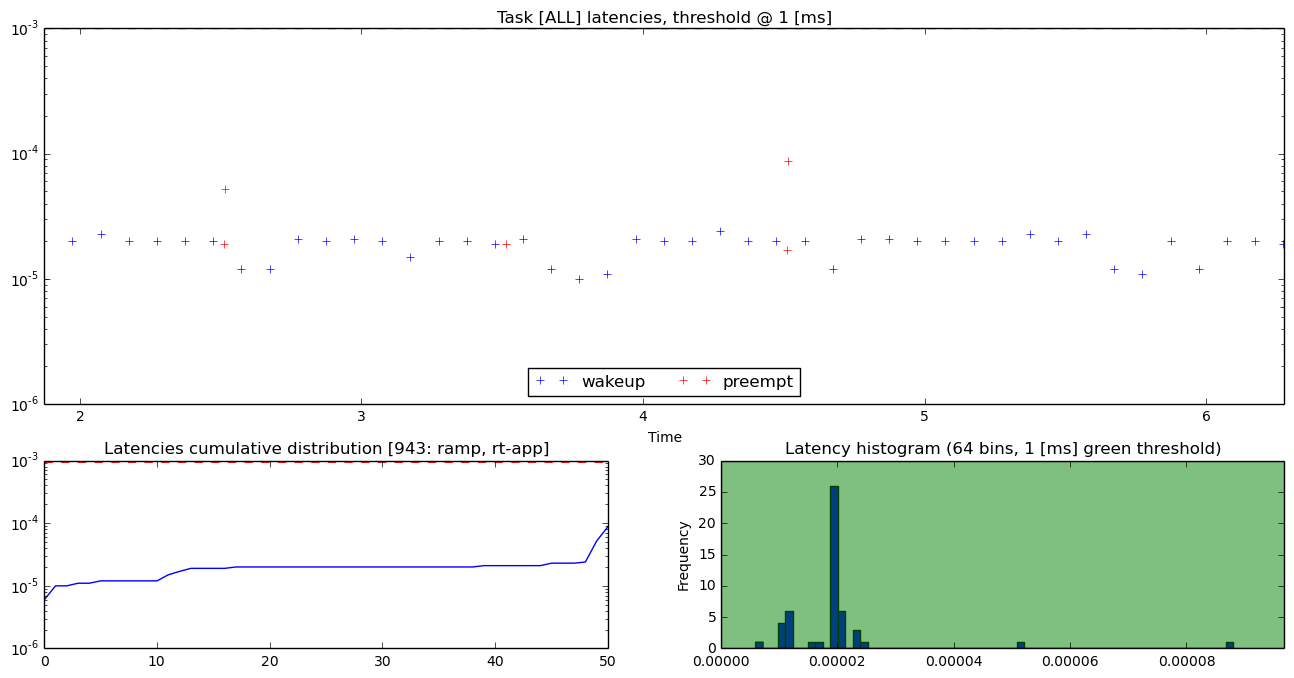

In [15]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [16]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max
latency,51.0,0.00002,0.000012,0.000006,0.00002,0.000024,0.00007,0.000088


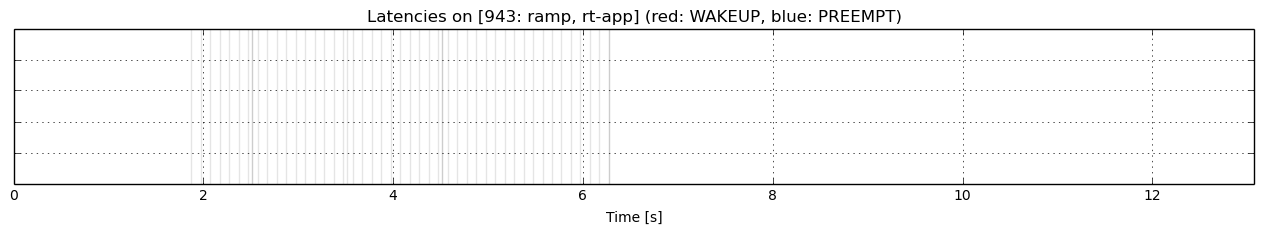

In [17]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

2016-12-12 13:00:07,509 INFO    : Trace        : Set plots time range to (3.445000, 3.450000)[s]


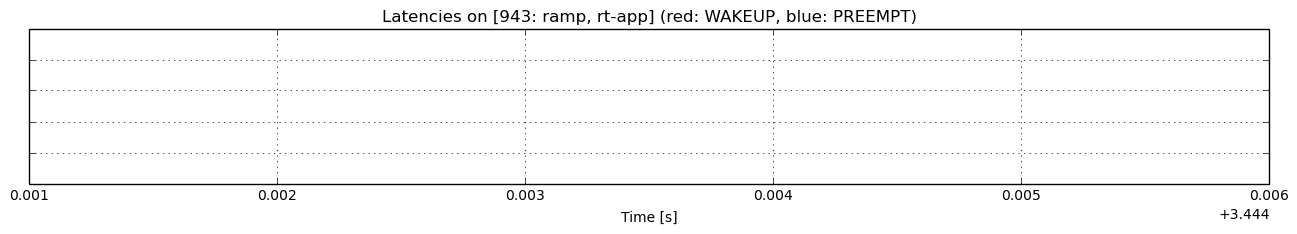

In [18]:
# Zoom into a spefific time frame
trace.setXTimeRange(3.445, 3.45)
trace.analysis.latency.plotLatencyBands('ramp')